# Installs and imports

In [ ]:
%%capture
!pip install "tensorflow-text==2.11.*"
#!pip install torch==2.1.0
#!pip install transformers

In [ ]:
#from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import torch
from collections import Counter

In [ ]:
corpus = pd.read_json('/content/Archive.json')

# Save the model

In [ ]:
import joblib

In [ ]:
joblib.dump(clust, "clustering_model.pkl")

['clustering_model.pkl']

In [ ]:
joblib.dump(tfidf, "tfidf_model.pkl")

['tfidf_model.pkl']

In [ ]:
clustering_model = joblib.load("clustering_model.pkl")

In [ ]:
tfidf_model = joblib.load("tfidf_model.pkl")

# Hierarchical Agglomerative Clustering

In [ ]:
import matplotlib as plt

In [ ]:
%%capture
!pip install sentence_transformers funcy pickle5

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import math

In [ ]:
from collections import defaultdict
import numpy as np
from joblib import Parallel, delayed
from funcy import log_durations
import logging
from tqdm import tqdm
import math
import numpy as np
import torch
from joblib import delayed
from tqdm import tqdm
from torch import Tensor
import pickle5 as pickle
import os

In [ ]:
def get_embeddings(ids, embeddings):
    return np.array([embeddings[idx] for idx in ids])


def reorder_and_filter_cluster(
    cluster_idx, cluster, cluster_embeddings, cluster_head_embedding, threshold
):
    cos_scores = cos_sim(cluster_head_embedding, cluster_embeddings)
    sorted_vals, indices = torch.sort(cos_scores[0], descending=True)
    bigger_than_threshold = sorted_vals > threshold
    indices = indices[bigger_than_threshold]
    sorted_vals = sorted_vals.numpy()
    return cluster_idx, [(cluster[i][0], sorted_vals[i]) for i in indices]


def get_ids(cluster):
    return [transaction[0] for transaction in cluster]


def reorder_and_filter_clusters(clusters, embeddings, threshold, parallel):
    results = parallel(
        delayed(reorder_and_filter_cluster)(
            cluster_idx,
            cluster,
            get_embeddings(get_ids(cluster), embeddings),
            get_embeddings([cluster_idx], embeddings),
            threshold,
        )
        for cluster_idx, cluster in tqdm(clusters.items())
    )

    clusters = {k: v for k, v in results}

    return clusters


def get_clustured_ids(clusters):
    clustered_ids = set(
        [transaction[0] for cluster in clusters.values() for transaction in cluster]
    )
    clustered_ids |= set(clusters.keys())
    return clustered_ids


def get_clusters_ids(clusters):
    return list(clusters.keys())


def get_unclustured_ids(ids, clusters):
    clustered_ids = get_clustured_ids(clusters)
    unclustered_ids = list(set(ids) - clustered_ids)
    return unclustered_ids


def sort_clusters(clusters):
    return dict(
        sorted(clusters.items(), key=lambda x: len(x[1]), reverse=True)
    )  # sort based on size


def sort_cluster(cluster):
    return list(
        sorted(cluster, key=lambda x: x[1], reverse=True)
    )  # sort based on similarity


def filter_clusters(clusters, min_cluster_size):
    return {k: v for k, v in clusters.items() if len(v) >= min_cluster_size}


def unique(collection):
    return list(dict.fromkeys(collection))


def unique_txs(collection):
    seen = set()
    return [x for x in collection if not (x[0] in seen or seen.add(x[0]))]


def write_pickle(data, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)


def chunk(txs, chunk_size):
    n = math.ceil(len(txs) / chunk_size)
    k, m = divmod(len(txs), n)
    return (txs[i * k + min(i, m) : (i + 1) * k + min(i + 1, m)] for i in range(n))



def online_community_detection(
    ids,
    embeddings,
    clusters=None,
    threshold=0.7,
    min_cluster_size=3,
    chunk_size=2500,
    iterations=10,
    cores=1,
):
    if clusters is None:
        clusters = {}

    with Parallel(n_jobs=cores) as parallel:
        for iteration in range(iterations):
            print("1. Nearest cluster")
            unclustered_ids = get_unclustured_ids(ids, clusters)
            cluster_ids = list(clusters.keys())
            print("Unclustured", len(unclustered_ids))
            print("Clusters", len(cluster_ids))
            clusters = nearest_cluster(
                unclustered_ids,
                embeddings,
                clusters,
                chunk_size=chunk_size,
                parallel=parallel,
            )
            print("\n\n")

            print("2. Create new clusters")
            unclustered_ids = get_unclustured_ids(ids, clusters)
            print("Unclustured", len(unclustered_ids))
            new_clusters = create_clusters(
                unclustered_ids,
                embeddings,
                clusters={},
                min_cluster_size=3,
                chunk_size=chunk_size,
                threshold=threshold,
                parallel=parallel,
            )
            new_cluster_ids = list(new_clusters.keys())
            print("\n\n")

            print("3. Merge new clusters", len(new_cluster_ids))
            max_clusters_size = 25000
            while True:
                new_cluster_ids = list(new_clusters.keys())
                old_new_cluster_ids = new_cluster_ids
                try:
                  new_clusters = create_clusters(
                      new_cluster_ids,
                      embeddings,
                      new_clusters,
                      min_cluster_size=1,
                      chunk_size=max_clusters_size,
                      threshold=threshold,
                      parallel=parallel,
                  )
                except:
                  return clusters
                new_clusters = filter_clusters(new_clusters, 2)

                new_cluster_ids = list(new_clusters.keys())
                print("New merged clusters", len(new_cluster_ids))
                if len(old_new_cluster_ids) < max_clusters_size:
                    break

            new_clusters = filter_clusters(new_clusters, min_cluster_size)
            print(
                f"New clusters with min community size >= {min_cluster_size}",
                len(new_clusters),
            )
            clusters = {**new_clusters, **clusters}
            print("Total clusters", len(clusters))
            clusters = sort_clusters(clusters)
            print("\n\n")

            print("4. Nearest cluster")
            unclustered_ids = get_unclustured_ids(ids, clusters)
            cluster_ids = list(clusters.keys())
            print("Unclustured", len(unclustered_ids))
            print("Clusters", len(cluster_ids))
            clusters = nearest_cluster(
                unclustered_ids,
                embeddings,
                clusters,
                chunk_size=chunk_size,
                parallel=parallel,
            )
            clusters = sort_clusters(clusters)

            unclustered_ids = get_unclustured_ids(ids, clusters)
            clustured_ids = get_clustured_ids(clusters)
            print("Clustured", len(clustured_ids))
            print("Unclustured", len(unclustered_ids))
            print(
                f"Percentage clustured {len(clustured_ids) / (len(clustured_ids) + len(unclustered_ids)) * 100:.2f}%"
            )

            print("\n\n")
    return clusters


def get_ids(cluster):
    return [transaction[0] for transaction in cluster]


def nearest_cluster_chunk(
    chunk_ids, chunk_embeddings, cluster_ids, cluster_embeddings, threshold
):
    cos_scores = cos_sim(chunk_embeddings, cluster_embeddings)
    top_val_large, top_idx_large = cos_scores.topk(k=1, largest=True)
    top_idx_large = top_idx_large[:, 0].tolist()
    top_val_large = top_val_large[:, 0].tolist()
    cluster_assignment = []
    for i, (score, idx) in enumerate(zip(top_val_large, top_idx_large)):
        cluster_id = cluster_ids[idx]
        if score < threshold:
            cluster_id = None
        cluster_assignment.append(((chunk_ids[i], score), cluster_id))
    return cluster_assignment


def nearest_cluster(
    transaction_ids,
    embeddings,
    clusters=None,
    parallel=None,
    threshold=0.75,
    chunk_size=2500,
):
    cluster_ids = list(clusters.keys())
    if len(cluster_ids) == 0:
        return clusters
    cluster_embeddings = get_embeddings(cluster_ids, embeddings)

    c = list(chunk(transaction_ids, chunk_size))

    with log_durations(logging.info, "Parallel jobs nearest cluster"):
        out = parallel(
            delayed(nearest_cluster_chunk)(
                chunk_ids,
                get_embeddings(chunk_ids, embeddings),
                cluster_ids,
                cluster_embeddings,
                threshold,
            )
            for chunk_ids in tqdm(c)
        )
        cluster_assignment = [assignment for sublist in out for assignment in sublist]

    for (transaction_id, similarity), cluster_id in cluster_assignment:
        if cluster_id is None:
            continue
        clusters[cluster_id].append(
            (transaction_id, similarity)
        )  # TODO sort in right order

    clusters = {
        cluster_id: unique_txs(sort_cluster(cluster))
        for cluster_id, cluster in clusters.items()
    }  # Sort based on similarity

    return clusters


def create_clusters(
    ids,
    embeddings,
    clusters=None,
    parallel=None,
    min_cluster_size=3,
    threshold=0.75,
    chunk_size=2500,
):
    to_cluster_ids = np.array(ids)
    np.random.shuffle(
        to_cluster_ids
    )  # TODO evaluate performance without, try sorted list

    c = list(chunk(to_cluster_ids, chunk_size))

    with log_durations(logging.info, "Parallel jobs create clusters"):
        out = parallel(
            delayed(fast_clustering)(
                chunk_ids,
                get_embeddings(chunk_ids, embeddings),
                threshold,
                min_cluster_size,
            )
            for chunk_ids in tqdm(c)
        )

    # Combine output
    new_clusters = {}
    for out_clusters in out:
        for idx, cluster in out_clusters.items():
            # new_clusters[idx] = unique([(idx, 1)] + new_clusters.get(idx, []) + cluster)
            new_clusters[idx] = unique_txs(cluster + new_clusters.get(idx, []))

    # Add ids from old cluster to new cluster
    for cluster_idx, cluster in new_clusters.items():
        community_extended = []
        for (idx, similarity) in cluster:
            community_extended += [(idx, similarity)] + clusters.get(idx, [])
        new_clusters[cluster_idx] = unique_txs(community_extended)

    new_clusters = reorder_and_filter_clusters(
        new_clusters, embeddings, threshold, parallel
    )  # filter to keep only the relevant
    new_clusters = sort_clusters(new_clusters)

    clustered_ids = set()
    for idx, cluster_ids in new_clusters.items():
        filtered = set(cluster_ids) - clustered_ids
        cluster_ids = [
            cluster_idx for cluster_idx in cluster_ids if cluster_idx in filtered
        ]
        new_clusters[idx] = cluster_ids
        clustered_ids |= set(cluster_ids)

    new_clusters = filter_clusters(new_clusters, min_cluster_size)
    new_clusters = sort_clusters(new_clusters)
    return new_clusters


def fast_clustering(ids, embeddings, threshold=0.70, min_cluster_size=10):
    """
    Function for Fast Clustering

    Finds in the embeddings all communities, i.e. embeddings that are close (closer than threshold).
    """

    # Compute cosine similarity scores
    cos_scores = cos_sim(embeddings, embeddings)

    # Step 1) Create clusters where similarity is bigger than threshold
    bigger_than_threshold = cos_scores >= threshold
    indices = bigger_than_threshold.nonzero()

    cos_scores = cos_scores.numpy()

    extracted_clusters = defaultdict(lambda: [])
    for row, col in indices.tolist():
        extracted_clusters[ids[row]].append((ids[col], cos_scores[row, col]))

    extracted_clusters = sort_clusters(extracted_clusters)  # FIXME

    # Step 2) Remove overlapping clusters
    unique_clusters = {}
    extracted_ids = set()

    for cluster_id, cluster in extracted_clusters.items():
        add_cluster = True
        for transaction in cluster:
            if transaction[0] in extracted_ids:
                add_cluster = False
                break

        if add_cluster:
            unique_clusters[cluster_id] = cluster
            for transaction in cluster:
                extracted_ids.add(transaction[0])

    new_clusters = {}
    for cluster_id, cluster in unique_clusters.items():
        community_extended = []
        for idx in cluster:
            community_extended.append(idx)
        new_clusters[cluster_id] = unique_txs(community_extended)

    new_clusters = filter_clusters(new_clusters, min_cluster_size)

    return new_clusters


In [ ]:
def cos_sim(a: Tensor, b: Tensor):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(np.array(a))

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(np.array(b))

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

In [ ]:
ids = corpus.DocId

In [ ]:
corpus.columns

Index(['DocId', 'Title', 'Date', 'Authors', 'Abstract', 'Embeddings', 'Year',
       'Month', 'Link', 'TandA', 'cluster_id', 'Keywords_new', 'DocKeywords'],
      dtype='object')

In [ ]:
embeddings = {idx: np.array(corpus[corpus['DocId']==idx].iloc[0]['Embeddings'][0]) for idx in ids}

In [ ]:
len(embeddings)

20000

In [ ]:
clusters = {}
clusters = online_community_detection(ids, embeddings, clusters, threshold = 0.5, chunk_size=5000)

1. Nearest cluster
Unclustured 20000
Clusters 0



2. Create new clusters
Unclustured 20000


100%|██████████| 1117/1117 [00:01<00:00, 1011.87it/s]





3. Merge new clusters 1117


100%|██████████| 643/643 [00:00<00:00, 2261.74it/s]


New merged clusters 643
New clusters with min community size >= 3 643
Total clusters 643



4. Nearest cluster
Unclustured 14042
Clusters 643


100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


Clustured 5970
Unclustured 14030
Percentage clustured 29.85%



1. Nearest cluster
Unclustured 14030
Clusters 643


100%|██████████| 3/3 [00:00<00:00, 10.79it/s]





2. Create new clusters
Unclustured 14030


100%|██████████| 890/890 [00:00<00:00, 2328.90it/s]





3. Merge new clusters 890


100%|██████████| 607/607 [00:00<00:00, 2377.57it/s]


New merged clusters 607
New clusters with min community size >= 3 607
Total clusters 1250



4. Nearest cluster
Unclustured 9692
Clusters 1250


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Clustured 10314
Unclustured 9686
Percentage clustured 51.57%



1. Nearest cluster
Unclustured 9686
Clusters 1250


100%|██████████| 2/2 [00:00<00:00,  5.63it/s]





2. Create new clusters
Unclustured 9686


100%|██████████| 611/611 [00:00<00:00, 2097.35it/s]





3. Merge new clusters 611


100%|██████████| 526/526 [00:00<00:00, 2089.60it/s]


New merged clusters 526
New clusters with min community size >= 3 526
Total clusters 1776



4. Nearest cluster
Unclustured 6754
Clusters 1776


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Clustured 13247
Unclustured 6753
Percentage clustured 66.23%



1. Nearest cluster
Unclustured 6753
Clusters 1776


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]





2. Create new clusters
Unclustured 6753


100%|██████████| 328/328 [00:00<00:00, 3688.29it/s]





3. Merge new clusters 328


100%|██████████| 285/285 [00:00<00:00, 3634.23it/s]


New merged clusters 285
New clusters with min community size >= 3 285
Total clusters 2061



4. Nearest cluster
Unclustured 5349
Clusters 2061


100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


Clustured 14652
Unclustured 5348
Percentage clustured 73.26%



1. Nearest cluster
Unclustured 5348
Clusters 2061


100%|██████████| 2/2 [00:00<00:00, 10.65it/s]





2. Create new clusters
Unclustured 5348


100%|██████████| 164/164 [00:00<00:00, 2893.12it/s]





3. Merge new clusters 164


100%|██████████| 153/153 [00:00<00:00, 2334.30it/s]


New merged clusters 153
New clusters with min community size >= 3 153
Total clusters 2214



4. Nearest cluster
Unclustured 4760
Clusters 2214


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Clustured 15240
Unclustured 4760
Percentage clustured 76.20%



1. Nearest cluster
Unclustured 4760
Clusters 2214


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]





2. Create new clusters
Unclustured 4760


100%|██████████| 182/182 [00:00<00:00, 3500.27it/s]





3. Merge new clusters 182


100%|██████████| 182/182 [00:00<00:00, 3107.31it/s]


New merged clusters 182
New clusters with min community size >= 3 182
Total clusters 2396



4. Nearest cluster
Unclustured 4144
Clusters 2396


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Clustured 15856
Unclustured 4144
Percentage clustured 79.28%



1. Nearest cluster
Unclustured 4144
Clusters 2396


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]





2. Create new clusters
Unclustured 4144


100%|██████████| 3/3 [00:00<00:00, 1893.59it/s]





3. Merge new clusters 3


100%|██████████| 3/3 [00:00<00:00, 2635.72it/s]


New merged clusters 3
New clusters with min community size >= 3 3
Total clusters 2399



4. Nearest cluster
Unclustured 4135
Clusters 2399


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Clustured 15865
Unclustured 4135
Percentage clustured 79.33%



1. Nearest cluster
Unclustured 4135
Clusters 2399


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]





2. Create new clusters
Unclustured 4135


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]
0it [00:00, ?it/s]




3. Merge new clusters 0


# SKlearn KMeans Clustering

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(2,3))

In [ ]:
#tfidf blocks
text_corpus = corpus['TandA']
X = tfidf.fit_transform(text_corpus)
feature_names = np.array(tfidf.get_feature_names_out())
some = corpus['TandA']
responses = tfidf.transform(some)

In [ ]:
def retNew(arr):
  return arr[0]

In [ ]:
corpus['Embeddingss'] = corpus['Embeddings'].apply(retNew)

In [ ]:
X = np.array(corpus['Embeddingss'].tolist())

In [ ]:
clust = KMeans(init = 'k-means++', n_clusters = 200, n_init=10)
clust.fit(X)
y = clust.predict(X)
#corpus['labels'] = clust.labels_

In [ ]:
y = clust.predict(responses)

In [ ]:
corpus['new_clusters'] = y

In [ ]:
corpus[corpus['new_clusters']==2]

,DocId,Title,Date,Authors,Abstract,Embeddings,Year,Month,Link,TandA,cluster_id,Keywords_new,DocKeywords,Embeddingss,new_clusters
167,168,Blowup dynamics for equivariant critical Landa...,"[2022/12/31, 2022, 12]","[[Han, Fangyu], [Tan, Zhong]]",The existence of finite time blowup solutions ...,"[[-0.3112927079, 0.0429057032, 0.0972931385, 0...",2022,12,http://arxiv.org/pdf/2301.00168.pdf,Blowup dynamics equivariant critical flow exis...,62,"[lowest energy steady, perturbative analysis s...","[lowest energy steady, perturbative analysis s...","[-0.3112927079, 0.0429057032, 0.0972931385, 0....",2
204,205,Gevrey-class-3 regularity of the linearised hy...,"[2022/12/31, 2022, 12]","[[DeAnna, Francesco], [Kortum, Joshua], [Scrob...","In the present paper, we address a physically-...","[[-0.2308457941, 0.1731960475, 0.1035471782, -...",2022,12,http://arxiv.org/pdf/2301.00205.pdf,regularity linearised hyperbolic Prandtl syste...,85,"[paper overcome dealing, prandtl given class, ...","[paper overcome dealing, prandtl given class, ...","[-0.2308457941, 0.1731960475, 0.1035471782, -0...",2
210,211,Asymptotically autonomous robustness in Probab...,"[2022/12/31, 2022, 12]","[[Kinra, Kush], [Mohan, ManilT.], [Wang, Renhai]]",This article is concerned with the \emph{asymp...,"[[-0.1259972453, -0.1270124912, -0.0470272563,...",2022,12,http://arxiv.org/pdf/2301.00211.pdf,Asymptotically autonomous robustness Probabili...,170,"[random attractors stochastic, asymptotically ...","[random attractors stochastic, asymptotically ...","[-0.1259972453, -0.1270124912, -0.0470272563, ...",2
225,226,Bounds on heat transport for two-dimensional b...,"[2022/12/31, 2022, 12]","[[Bleitner, Fabian], [Nobili, Camilla]]",We consider the two-dimensional Rayleigh-B\&#3...,"[[-0.0862507522, 0.020923888300000002, 0.18594...",2022,12,http://arxiv.org/pdf/2301.00226.pdf,Bounds heat transport buoyancy driven flows ro...,8,"[prove rigorous upper, predicted scaling bound...","[prove rigorous upper, predicted scaling bound...","[-0.0862507522, 0.020923888300000002, 0.185940...",2
284,285,On the Smoothness of the Solution to the Two-D...,"[2022/12/31, 2022, 12]","[[Wang, Dean]]","In this paper, we deal with the differential p...","[[-0.09426344930000001, 0.0453404374, 0.130671...",2022,12,http://arxiv.org/pdf/2301.00285.pdf,Smoothness Solution Radiation Transfer Equatio...,2,"[radiation transfer estimates, based regularit...","[radiation transfer estimates, based regularit...","[-0.09426344930000001, 0.0453404374, 0.1306715...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19130,19131,A chemotaxis-Navier-Stokes system with dynamic...,"[2023/06/07, 2023, 6]","[[Chen, Baili]]",A chemotaxis-Navier-Stokes system is studied u...,"[[-0.1032360345, -0.0983073562, 0.348548948800...",2023,6,http://arxiv.org/pdf/2306.04131.pdf,system dynamical boundary conditions system st...,64,"[dynamical boundary conditions, layers approxi...","[dynamical boundary conditions, layers approxi...","[-0.1032360345, -0.0983073562, 0.3485489488000...",2
19269,19270,Some remarks about the stationary Micropolar f...,"[2023/06/07, 2023, 6]","[[Chamorro, Diego], [Llerena, David], [Vergara...",We consider here the stationary Micropolar flu...,"[[-0.1675479263, 0.07382331040000001, 0.153699...",2023,6,http://arxiv.org/pdf/2306.04270.pdf,remarks stationary Micropolar fluid regularity...,167,"[stationary micropolar fluid, microrotations f...","[stationary micropolar fluid, microrotations f...","[-0.1675479263, 0.07382331040000001, 0.1536990...",2
19412,19413,Global convergence towards pushed travelling f...,"[2023/06/07, 2023, 6]","[[Oliver-Bonafoux, Ramon], [Risler, Emmanuel]]",This article addresses the issue of global con...,"[[-0.06683416660000001, -0.1994747818, 0.04185...",2023,6,http://arxiv.org/pdf/2306.04413.pdf,Global convergence pushed travelling fronts pa...,64,"[greater linear spreading, speed greater linea...","[greater linear spreading, speed greater linea...","[-0.066834166600

In [ ]:
corpus.to_json('corpusss.json')

# Choosing k

In [ ]:
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow method
wcss = []  # within-cluster sum of squares
for k in range(50, 350, 50):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
wcss

[88088.8620128427,
 83721.3233298657,
 81193.90588257584,
 79357.48156839744,
 77916.7788558857,
 76826.61776300805]

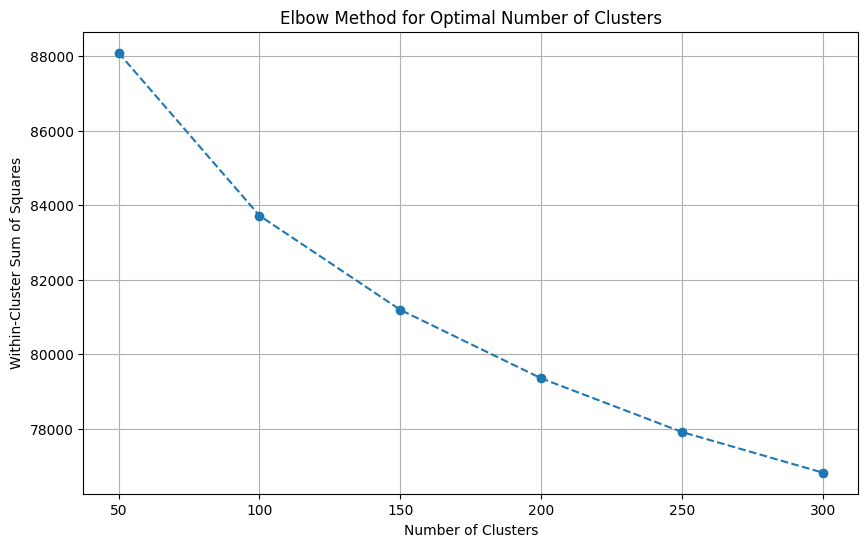

In [ ]:
# Plot the Elbow method
plt.figure(figsize=(10, 6))
plt.plot([50,100,150,200,250,300], wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

# Visualizing with Decomposed Vectors

In [ ]:
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#sampling clusters 0- 50
df = corpus[corpus['new_clusters']<10]
#df = corpus[corpus['cluster_id']<10]

In [ ]:
somes = np.array(list(df['Embeddingss']))

In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA and reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_tfidf = pca.fit_transform(somes)

reduced_tfidf.shape

(1012, 2)

In [ ]:
corpus.columns

Index(['DocId', 'Title', 'Date', 'Authors', 'Abstract', 'Embeddings', 'Year',
       'Month', 'Link', 'TandA', 'cluster_id', 'Keywords_new', 'DocKeywords',
       'Embeddingss', 'new_clusters'],
      dtype='object')

In [ ]:
# Create DF
embeddingsdf = pd.DataFrame()
# Add game names
embeddingsdf['title'] = df.Title
embeddingsdf['tfidf_cluster'] = df.cluster_id
embeddingsdf['bert_cluster'] = df.new_clusters
# Add x coordinate
embeddingsdf['x'] = reduced_tfidf[:,0]
# Add y coordinate
embeddingsdf['y'] = reduced_tfidf[:,1]
# Check
embeddingsdf.head()

,title,tfidf_cluster,bert_cluster,x,y
0,NFTrig,98,5,0.066803,0.310267
4,Intrinsic Motivation in Dynamical Control Systems,146,8,-0.454930,-0.514777
8,On the Geometry of Reinforcement Learning in C...,191,8,-0.452092,-0.700594
12,Don&#39;t throw that video away! Reference Fra...,85,4,-0.753614,0.962656
31,Bayesian Learning for Dynamic Inference,2,9,-0.263266,-0.595538


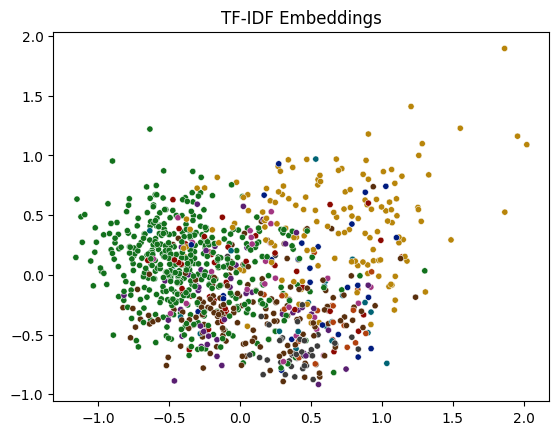

In [ ]:

# Create a scatter plot
fig1 = sns.scatterplot(x=embeddingsdf['x'], y=embeddingsdf['y'], hue=embeddingsdf['tfidf_cluster'], palette='dark',s = 20, legend=False)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('TF-IDF Embeddings')

# Show the plot
plt.show()

In [ ]:
fig = fig1.get_figure()
fig.savefig('tfidf', bbox_inches='tight')

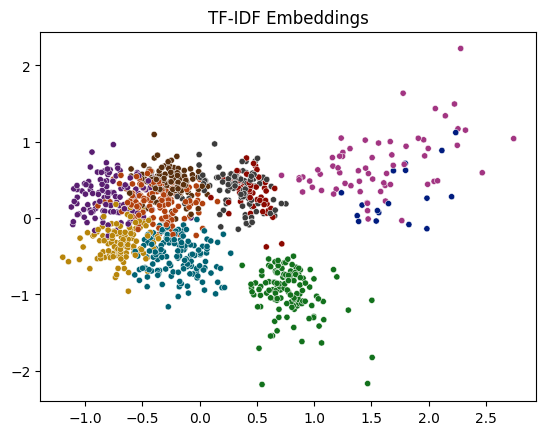

In [ ]:
# Create a scatter plot
fig2 = sns.scatterplot(x=embeddingsdf['x'], y=embeddingsdf['y'], hue=embeddingsdf['bert_cluster'], palette='dark',s = 20, legend=False)

# Add labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('TF-IDF Embeddings')

# Show the plot
plt.show()

In [ ]:
fig = fig2.get_figure()
fig.savefig('bert', bbox_inches='tight')